# Problem statement: 
#### The goal of this project is to develop a machine learning model that accurately identifies and classifies rice leaf diseases from images, enabling early detection and effective management of bacterial blight,  brown spot and leaf smut.


### Import Libraries

In [1]:
# Import necessary libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Import Frameworks

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
import zipfile
import os

# Define the paths to the uploaded zip files
zip_files = [
    '/Users/thakshilashilpadi/Downloads/Rice Leaf diseases/Bacterial leaf blight-20200814T055237Z-001.zip',
    '/Users/thakshilashilpadi/Downloads/Rice Leaf diseases/Brown spot-20200814T055208Z-001.zip',
    '/Users/thakshilashilpadi/Downloads/Rice Leaf diseases/Leaf smut-20200814T055530Z-001.zip'
]

# Create a directory to extract the contents
extracted_dir = '/Users/thakshilashilpadi/Downloads/Rice Leaf diseases/data/extracted_datasets'
os.makedirs(extracted_dir, exist_ok=True)

# Extract the contents of each zip file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

# List the extracted contents
extracted_contents = os.listdir(extracted_dir)
extracted_contents

['Bacterial leaf blight', 'Leaf smut', 'Brown spot']

#### Data Directories
Each directory contains a collection of image files representing the respective diseases. Here are the contents
* Bacterial leaf blight: 40 image files (various .JPG and .jpg formats).
* Brown spot: 40 image files (various .JPG and .jpg formats).
* Leaf smut: 40 image files (various .JPG and .jpg formats).

In [3]:
# List the contents of each directory
bacterial_leaf_blight_dir = os.path.join(extracted_dir, 'Bacterial leaf blight')
brown_spot_dir = os.path.join(extracted_dir, 'Brown spot')
leaf_smut_dir = os.path.join(extracted_dir, 'Leaf smut')

bacterial_leaf_blight_files = os.listdir(bacterial_leaf_blight_dir)
brown_spot_files = os.listdir(brown_spot_dir)
leaf_smut_files = os.listdir(leaf_smut_dir)

bacterial_leaf_blight_files, brown_spot_files, leaf_smut_files


(['DSC_0385.jpg',
  'DSC_0390.JPG',
  'DSC_0384.JPG',
  'DSC_0392.JPG',
  'DSC_0386.JPG',
  'DSC_0379.JPG',
  'DSC_0378.JPG',
  'DSC_0393.JPG',
  'DSC_0397.JPG',
  'DSC_0383.JPG',
  'DSC_0382.JPG',
  'DSC_0396.JPG',
  'DSC_0380.JPG',
  'DSC_0395.JPG',
  'DSC_0381.JPG',
  'DSC_0700.jpg',
  'DSC_0701.jpg',
  'DSC_0703.JPG',
  'DSC_0702.jpg',
  'DSC_0398.JPG',
  'DSC_0367.JPG',
  'DSC_0401.JPG',
  'DSC_0373.JPG',
  'DSC_0372.JPG',
  'DSC_0366.jpg',
  'DSC_0400.JPG',
  'DSC_0399.JPG',
  'DSC_0370.jpg',
  'DSC_0402.JPG',
  'DSC_0403.JPG',
  'DSC_0365.JPG',
  'DSC_0375.JPG',
  'DSC_0406.JPG',
  'DSC_0374.JPG',
  'DSC_0389.JPG',
  'DSC_0404.JPG',
  'DSC_0376.JPG',
  'DSC_0377.JPG',
  'DSC_0405.JPG',
  'DSC_0388.JPG'],
 ['DSC_0391.jpg',
  'DSC_0394.jpg',
  'DSC_0325.JPG',
  'DSC_0292.JPG',
  'DSC_0324.JPG',
  'DSC_0332.JPG',
  'DSC_0118.jpg',
  'DSC_0119.jpg',
  'DSC_0333.JPG',
  'DSC_0337.JPG',
  'DSC_0323.JPG',
  'DSC_0109.jpg',
  'DSC_0121.jpg',
  'DSC_0295.JPG',
  'DSC_0108.jpg',
  'DSC_02

### Data Overview
Let's start by displaying a few sample images from each category to understand the visual characteristics of the data.

Bacterial Leaf Blight Samples:


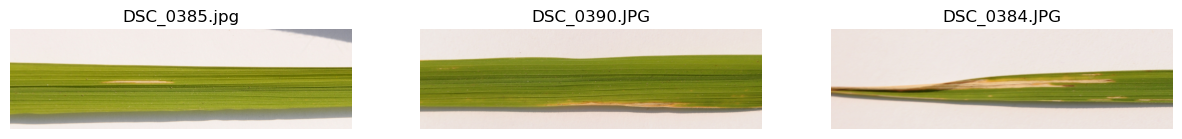

Brown Spot Samples:


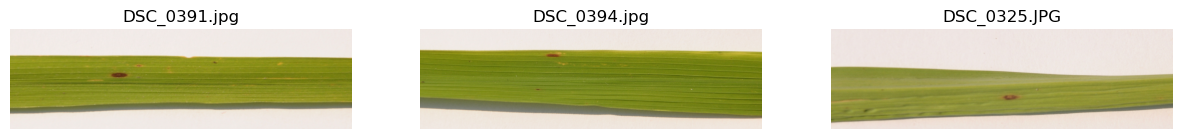

Leaf Smut Samples:


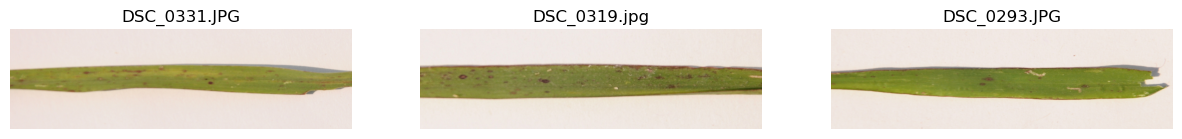

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display sample images from a directory
def display_sample_images(image_dir, num_samples=3):
    files = os.listdir(image_dir)[:num_samples]
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img = mpimg.imread(os.path.join(image_dir, file))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
    plt.show()

# Display sample images from each category
print("Bacterial Leaf Blight Samples:")
display_sample_images(bacterial_leaf_blight_dir)

print("Brown Spot Samples:")
display_sample_images(brown_spot_dir)

print("Leaf Smut Samples:")
display_sample_images(leaf_smut_dir)


The images above provide a glimpse into the visual characteristics of the different rice leaf diseases. Each disease category has unique visual features that can be used to distinguish between them.

### Data Visualization
We can visualize more images as needed, but for now, let's move on to the next steps in our data analysis.

### Data Preprocessing
To prepare the data for modeling, we'll need to perform several preprocessing steps:

* Resizing: Standardizing the image sizes to a uniform dimension.
* Normalization: Scaling pixel values to a range suitable for model training.
* Data Augmentation: Applying transformations like rotations, flips, and zooms to increase the dataset size and variability.

In [5]:
from PIL import Image
import numpy as np

# Define the target size for the images
target_size = (128, 128)

# Function to preprocess images: resize and normalize
def preprocess_image(image_path):
    with Image.open(image_path) as img:
        # Resize the image
        img = img.resize(target_size)
        # Convert the image to a numpy array and normalize pixel values
        img_array = np.array(img) / 255.0
    return img_array

# Preprocess a sample image from each category
sample_bacterial_leaf_blight = preprocess_image(os.path.join(bacterial_leaf_blight_dir, bacterial_leaf_blight_files[0]))
sample_brown_spot = preprocess_image(os.path.join(brown_spot_dir, brown_spot_files[0]))
sample_leaf_smut = preprocess_image(os.path.join(leaf_smut_dir, leaf_smut_files[0]))

sample_bacterial_leaf_blight.shape, sample_brown_spot.shape, sample_leaf_smut.shape


((128, 128, 3), (128, 128, 3), (128, 128, 3))

In [6]:

# Data Preprocessing: Resize and normalize images
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array

### Feature Extraction
We can use various techniques for feature extraction, such as:

* Manual Feature Extraction: Using image processing techniques to extract features like edges, textures, and color histograms.
* Deep Learning Features: Leveraging pre-trained convolutional neural networks (CNNs) to extract high-level features.

In [7]:
# Load and preprocess images from a directory
def load_images_from_directory(directory, label, target_size=(128, 128)):
    images = []
    labels = []
    for file in os.listdir(directory):
        img_path = os.path.join(directory, file)
        img_array = preprocess_image(img_path, target_size)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
# Load and preprocess all images
bacterial_leaf_blight_images, bacterial_leaf_blight_labels = load_images_from_directory(bacterial_leaf_blight_dir, 0)
brown_spot_images, brown_spot_labels = load_images_from_directory(brown_spot_dir, 1)
leaf_smut_images, leaf_smut_labels = load_images_from_directory(leaf_smut_dir, 2)



In [9]:
# Combine the datasets
X = np.concatenate([bacterial_leaf_blight_images, brown_spot_images, leaf_smut_images])
y = np.concatenate([bacterial_leaf_blight_labels, brown_spot_labels, leaf_smut_labels])

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)


### Modeling Approach
For the classification task, we can consider the following models:

1. Traditional Machine Learning Models:

* Support Vector Machines (SVM)
* Random Forests
* k-Nearest Neighbors (k-NN)

2. Deep Learning Models:

* Convolutional Neural Networks (CNNs)
* Transfer Learning with pre-trained models (e.g., VGG16, ResNet50)

In [29]:
# Create a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), epochs=25, validation_data=(X_test, y_test))


Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.2760 - loss: 1.3631 - val_accuracy: 0.2917 - val_loss: 1.1117
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2615 - loss: 1.1089 - val_accuracy: 0.2917 - val_loss: 1.0934
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3274 - loss: 1.0910 - val_accuracy: 0.3333 - val_loss: 1.0686
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4753 - loss: 1.0619 - val_accuracy: 0.3333 - val_loss: 1.0849
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4315 - loss: 1.0397 - val_accuracy: 0.4583 - val_loss: 1.0340
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3567 - loss: 1.0726 - val_accuracy: 0.3750 - val_loss: 1.0336
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4713 - loss: 1.0274 - val_accuracy: 0.3750 - val_loss: 1.0274
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4664 - loss: 1.0337 - val_accuracy: 0.4167 - v

### Evaluation Matrix
We will use the following metrics to evaluate our models:

* Accuracy: The proportion of correctly classified instances.
* Precision, Recall, and F1-Score: To evaluate the performance on each class.
* Confusion Matrix: To visualize the performance across different classes.

In [31]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.50      0.25      0.33         8
           2       0.70      0.78      0.74         9

    accuracy                           0.62        24
   macro avg       0.60      0.63      0.59        24
weighted avg       0.60      0.62      0.59        24

[[6 0 1]
 [4 2 2]
 [0 2 7]]


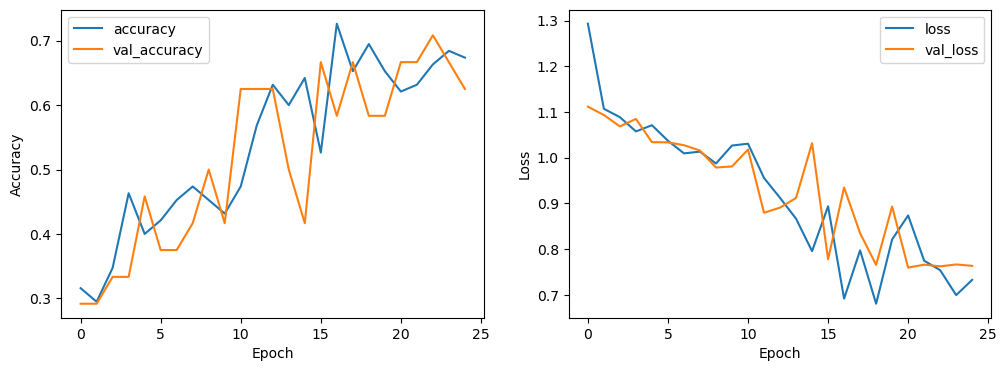

In [32]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()